# Transformer for UNSW-NB15 (Binary Classification)

This notebook trains a **Transformer** model for binary intrusion detection on the **UNSW-NB15** dataset.

**Key Features:**
- **Self-Attention**: Uses Multi-Head Self-Attention to capture complex relationships between features.
- **Architecture**: Encoder-only Transformer architecture adapted for tabular data.
- **Goal**: Classify traffic as **Normal** (0) or **Attack** (1).

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(str(Path("../../").resolve()))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import Transformer Model
from src.models.classical.transformer import TransformerClassifier

sns.set_theme(style="whitegrid")
torch.manual_seed(42)
np.random.seed(42)

c:\Users\musab\Projects\NIDS-DL\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
CONFIG = {
    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.0005,
    "weight_decay": 1e-4,
    "embed_dim": 64,
    "num_heads": 4,
    "ff_dim": 128,
    "num_blocks": 3,
    "dense_units": [64],
    "dropout": 0.3,
    "patience": 10,
}

CATEGORICAL_COLS = ['proto', 'service', 'state']
DROP_COLS = ['id', 'attack_cat']
LABEL_COL = 'label'

DATA_DIR = Path("../../data/raw/unsw-nb15")

def load_unsw_nb15(filepath, scaler=None, label_encoders=None, fit=True):
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
        
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df):,} samples from {filepath.name}")
    
    df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors='ignore')
    
    y = df[LABEL_COL].values
    X = df.drop(columns=[LABEL_COL])
    
    if fit:
        label_encoders = {}
        for col in CATEGORICAL_COLS:
            if col in X.columns:
                le = LabelEncoder()
                X[col] = X[col].fillna('unknown').astype(str)
                X[col] = le.fit_transform(X[col])
                label_encoders[col] = le
    else:
        for col in CATEGORICAL_COLS:
            if col in X.columns:
                X[col] = X[col].fillna('unknown').astype(str)
                X[col] = X[col].apply(lambda x: x if x in label_encoders[col].classes_ else 'unknown')
                if 'unknown' not in label_encoders[col].classes_:
                    label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'unknown')
                X[col] = label_encoders[col].transform(X[col])
    
    X = X.fillna(0)
    X_vals = X.values.astype(np.float32)
    X_vals = np.nan_to_num(X_vals, nan=0.0, posinf=0.0, neginf=0.0)
    
    if fit:
        scaler = StandardScaler()
        X_vals = scaler.fit_transform(X_vals)
    else:
        X_vals = scaler.transform(X_vals)
        
    return X_vals, y, scaler, label_encoders

In [3]:
try:
    # Load Data
    X_train, y_train, scaler, label_encoders = load_unsw_nb15(
        DATA_DIR / "UNSW_NB15_training-set.csv", fit=True
    )
    
    X_test, y_test, _, _ = load_unsw_nb15(
        DATA_DIR / "UNSW_NB15_testing-set.csv",
        scaler=scaler, label_encoders=label_encoders, fit=False
    )
    
    val_size = int(0.1 * len(X_train))
    indices = np.random.permutation(len(X_train))
    
    X_val = X_train[indices[:val_size]]
    y_val = y_train[indices[:val_size]]
    X_train = X_train[indices[val_size:]]
    y_train = y_train[indices[val_size:]]
    
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    
except FileNotFoundError:
    print("❌ Dataset not found! Please download UNSW-NB15 CSV files.")

Loaded 82,332 samples from UNSW_NB15_training-set.csv
Loaded 175,341 samples from UNSW_NB15_testing-set.csv
Train: (74099, 42), Val: (8233, 42), Test: (175341, 42)


## 2. Transformer Model Setup

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'X_train' in globals():
    model = TransformerClassifier(
        input_dim=X_train.shape[1],
        num_classes=2,
        embed_dim=CONFIG["embed_dim"],
        num_heads=CONFIG["num_heads"],
        ff_dim=CONFIG["ff_dim"],
        num_blocks=CONFIG["num_blocks"],
        dense_units=CONFIG["dense_units"],
        dropout=CONFIG["dropout"]
    ).to(device)
    
    print(f"Model on {device}")

    # Class weights
    class_counts = np.bincount(y_train)
    class_weights = torch.FloatTensor(len(y_train) / (2 * class_counts)).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    # DataLoaders
    train_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    test_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=CONFIG["batch_size"], shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=CONFIG["batch_size"], shuffle=False)

Model on cuda


c:\Users\musab\Projects\NIDS-DL\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += y_batch.size(0)
        correct += pred.eq(y_batch).sum().item()
    return total_loss/len(loader), correct/total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += y_batch.size(0)
            correct += pred.eq(y_batch).sum().item()
    return total_loss/len(loader), correct/total

In [8]:
if 'X_train' in globals():
    best_val_acc = 0
    
    for epoch in range(CONFIG["epochs"]):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate(model, val_loader)
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "../../results/models/transformer_unsw.pt")
            
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 5 | Train Acc: 0.8817 | Val Acc: 0.9070
Epoch 10 | Train Acc: 0.9104 | Val Acc: 0.9038
Epoch 15 | Train Acc: 0.9239 | Val Acc: 0.9367
Epoch 20 | Train Acc: 0.9321 | Val Acc: 0.9399
Epoch 25 | Train Acc: 0.9377 | Val Acc: 0.9396
Epoch 30 | Train Acc: 0.9407 | Val Acc: 0.9451
Epoch 35 | Train Acc: 0.9433 | Val Acc: 0.9474
Epoch 40 | Train Acc: 0.9467 | Val Acc: 0.9542
Epoch 45 | Train Acc: 0.9495 | Val Acc: 0.9548
Epoch 50 | Train Acc: 0.9507 | Val Acc: 0.9547


C:\Users\musab\AppData\Local\Temp\ipykernel_87180\673027304.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../../results/models/transf

Test Accuracy: 0.8831
              precision    recall  f1-score   support

      Normal       0.74      0.98      0.84     56000
      Attack       0.99      0.84      0.91    119341

    accuracy                           0.88    175341
   macro avg       0.86      0.91      0.88    175341
weighted avg       0.91      0.88      0.89    175341



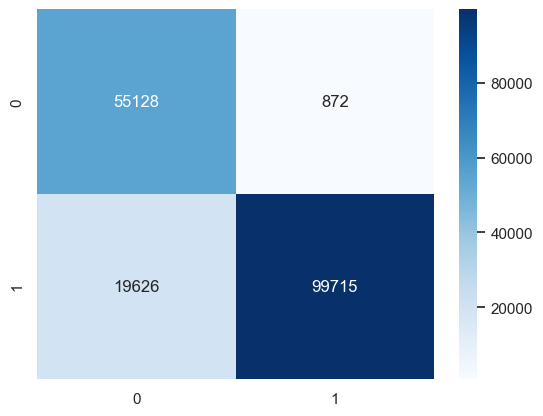

4149

In [9]:
if 'X_train' in globals():
    model.load_state_dict(torch.load("../../results/models/transformer_unsw.pt"))
    test_loss, test_acc = evaluate(model, test_loader)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, pred = outputs.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y_batch.numpy())
            
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Attack']))
    sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues')
    plt.show()

#Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()